In [2]:
import xarray as xr
import numpy as np
import os
import optuna
from glob import glob
import tqdm


import matplotlib.pyplot as plt
from matplotlib import cm as cmap
from matplotlib.lines import Line2D
import seaborn as sb
from cycler import cycler

In [28]:
colors = {
    0.5: 'tab:blue',
    1.5: 'tab:red',
    2.5: 'tab:purple'
}

In [63]:
rerun = False

if not rerun:
    raise ValueError(
        '`rerun=False`. set `True` if you want to rerun (~12 min).'
    )

paths = glob(f'../logs/experiment_02/lightning_logs/version_*/predictions.nc')
ds_all = xr.open_dataset(paths[0]).q10
ds_all.values[:] = np.nan
ds_all = ds_all.expand_dims(
    {'q10_init': [0.5, 1.5, 2.5], 'dropout': [0.0, 0.2, 0.4], 'weight_decay': [0.0, 0.01, 0.1], 'rep': np.arange(10), 'use_ta': [0, 1]}).copy()

ds_counter = xr.open_dataset(paths[0]).q10.isel(iter=0).drop('iter').expand_dims(
    {'q10_init': [0.5, 1.5, 2.5], 'dropout': [0.0, 0.2, 0.4], 'weight_decay': [0.0, 0.01, 0.1], 'use_ta': [0, 1]}).astype('int').copy()
ds_counter.values[:] = 0

error_count = 0
for i, p in enumerate(tqdm.tqdm(paths)):

    try:
        ds = xr.open_dataset(p)
    except:
        error_count += 1
        continue

    weight_decay = ds.attrs['weight_decay']
    q10_init = ds.attrs['q10_init']
    dropout = ds.attrs['dropout']
    use_ta = bool(ds.attrs['use_ta'])
    use_scheduler = bool(ds.attrs['use_scheduler'])

    if use_scheduler:
        continue

    rep = ds_counter.sel(q10_init=q10_init, dropout=dropout, weight_decay=weight_decay, use_ta=int(use_ta))

    if rep == 10:
        continue

    ds_all.loc[
        dict(
            q10_init=q10_init,
            dropout=dropout,
            weight_decay=weight_decay,
            use_ta=int(use_ta),
            rep=rep)
    ] = ds.q10.values

    ds_counter.loc[dict(q10_init=q10_init, dropout=dropout, weight_decay=weight_decay, use_ta=int(use_ta))] += 1

    if (ds_counter == 1).all().item():
        break

ds_all.to_netcdf('../logs/experiment_02/lightning_logs/predictions_grid.nc')

100%|██████████| 6972/6972 [10:46<00:00, 10.78it/s]


In [4]:
ds_all = xr.open_dataset('../logs/experiment_02/lightning_logs/predictions_grid.nc').load()

In [127]:
df_all = ds_all.to_dataframe().reset_index()

In [193]:
def plot_grid(df, with_temp):
    df = df[df['use_ta']==int(with_temp)]#.iloc[:100, :]
    g = sb.relplot(
        x='iter', y='q10', col='dropout', row='weight_decay', hue='q10_init', style='rep',
        data=df, kind='line', dashes=False, height=2, aspect=1.5, palette='colorblind', alpha=0.5)

    for i in range(g.axes.shape[0]):
        for j in range(g.axes.shape[1]):
            ax = g.axes[i, j]
            ax.axhline(1.5, ls=':', color='k', lw=1.4)

            if (i == 1) and (j == 0):
                ax.set_ylabel(r'$Q_{10}$')
            else:
                ax.set_ylabel('')

            if (i == 2) and (j == 1):
                ax.set_xlabel('Training iteration')
            else:
                ax.set_xlabel('')

    g.legend.remove()

    h, l = g.axes[0, 0].get_legend_handles_labels()

    g.axes[0, 1].legend(
        [Line2D([0], [0], color='k', ls=':', lw=1)] + h[1:4],
        [r'$Q_{10}$ true'] + l[1:4],
        frameon=False,
        ncol=4,
        title=r'$Q_{10}$ init',
        loc='lower center',
        bbox_to_anchor=(0.5, 1.1))

    #plt.savefig(f'./plots/q10_{"wi" if with_temp else "wo"}_ta.png', dpi=300, transparent=False, facecolor='w')
    g.savefig(f'./plots/q10_{"wi" if with_temp else "wo"}_ta.png', dpi=300, transparent=False, facecolor='w')

    return g

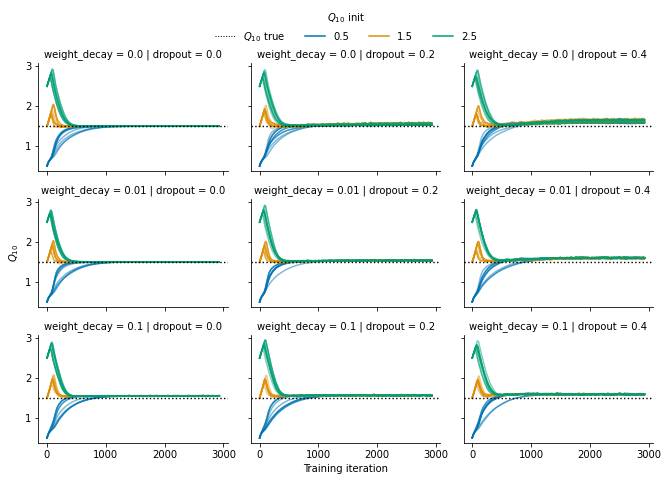

In [195]:
g = plot_grid(df_all, False)

In [201]:
study = optuna.study.load_study(study_name='q10hybrid', storage='sqlite:////Net/Groups/BGI/people/bkraft/git/q10hybrid/logs/experiment_02/optuna.db')
df = study.trials_dataframe()[[
    'value',
    'params_weight_decay',
    'params_q10_init',
    'params_dropout',
    'params_use_ta',
    'params_use_scheduler',
    'user_attrs_q10']]
df = df[df['params_use_scheduler'] == True]

In [202]:
df = df.rename(columns={
    'value': 'loss',
    'params_weight_decay': 'weight decay',
    'params_q10_init': 'Q10 init',
    'params_dropout': 'dropout',
    'user_attrs_q10': 'Q10',
    'params_use_ta': 'With temperature'
})
df

,loss,weight decay,Q10 init,dropout,With temperature,params_use_scheduler,Q10
1,0.040222,0.10,0.5,0.2,True,True,1.313839
2,0.000054,0.00,2.5,0.0,True,True,1.525596
3,0.003890,0.01,0.5,0.0,True,True,1.411915
4,0.000140,0.00,1.5,0.0,True,True,1.500347
5,0.000140,0.00,1.5,0.0,True,True,1.500347
...,...,...,...,...,...,...,...
7051,0.055213,0.10,0.5,0.4,False,True,1.591898
7052,0.055213,0.10,0.5,0.4,False,True,1.591898
7053,0.055213,0.10,0.5,0.4,False,True,1.591898
7054,0.055213,0.10,0.5,0.4,False,True,1.591898


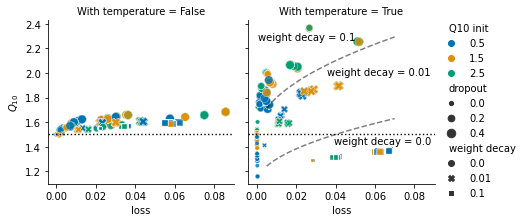

In [282]:
g = sb.relplot(x='loss', y='Q10', hue='Q10 init', size='dropout', col='With temperature', style='weight decay', data=df, palette='colorblind', height=3, aspect=1, alpha=0.8)

x = np.linspace(0.005, 0.07, 100)

#g.axes[0, 1].plot(x, np.sqrt(x)*10.1)
#g.axes[0, 1].plot(x, np.sqrt(x)*1.6)

ax = g.axes[0, 1]
ax.plot(x, np.sqrt(x) * 2 + 1.1, color='k', alpha=0.5, ls='--')
ax.plot(x, np.sqrt(x) * 3 + 1.5, color='k', alpha=0.5, ls='--')

ax.text(0.98, 0.26, f'weight decay = 0.0',
    horizontalalignment='right', verticalalignment='center', transform=ax.transAxes)
ax.text(0.98, 0.68, f'weight decay = 0.01',
    horizontalalignment='right', verticalalignment='center', transform=ax.transAxes)
ax.text(0.05, 0.9, f'weight decay = 0.1',
    horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)

g.axes[0, 0].axhline(1.5, ls=':', color='k', lw=1.4)
g.axes[0, 1].axhline(1.5, ls=':', color='k', lw=1.4)

g.axes[0, 0].set_ylabel(r'$Q_{10}$')

g.savefig(f'./plots/q10_interactions.png', dpi=300, transparent=False, facecolor='w')